# Multidimensional Scaling
## Theory And Applications

### Chris Tralie

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy
from numpy import linalg
import matplotlib.pyplot as plt
from matplotlib import animation

import skimage

from tqdm import tqdm
import IPython.display as ipd

from ytutils.utils import inline_video, inline_compressed_audio

## Distance Matrix Definitions

To be more specific, a *point cloud* is an unordered a collection of points, though in many of the applications that follow, we'll choose to index the points in a time order.

A *Euclidean point cloud* is a specific kind of point cloud where the points live in Euclidean space (e.g. a point cloud on the 2D Cartesian grid).  Data wise, we can think of it as a matrix, where each row is a set of coordinates for a point in Euclidean space.  For instance, a figure 8 with 101 points in the 2D Cartesian grid is a Euclidean point cloud, and here is how we might construct this in numpy, where we use the convention that captial $X$ is a point cloud variable

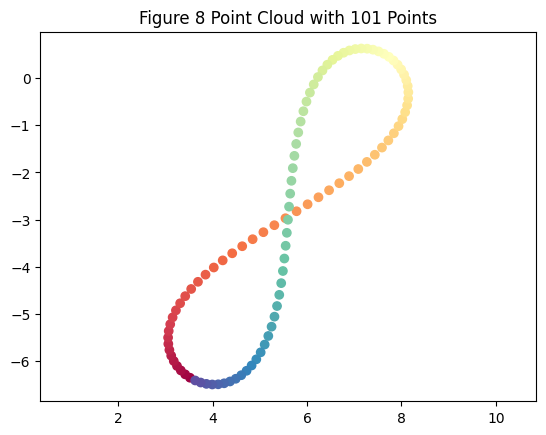

In [2]:
N = 101
ts = 2*np.pi*(np.linspace(0, 1, N+1))[0:N]

X = np.zeros((N, 2))
X[:, 0] = 4*np.cos(ts)
X[:, 1] = np.sin(2*ts)
np.random.seed(0)
# Apply a random rotation
R, _, _ = np.linalg.svd(np.random.randn(2, 2))
X = X.dot(R)
# Apply random translation
X += 3*np.random.randn(1, 2)


plt.scatter(X[:, 0], X[:, 1], c=np.arange(N), cmap='Spectral')
plt.axis("equal");
plt.title(f"Figure 8 Point Cloud with {N} Points")
plt.savefig("Figure8.png", dpi=300, bbox_inches='tight')

Now that we've define what we mean by shape, we can introduce distance matrices.  A *distance matrix* for a point cloud with $N$ points is a $N \times N$ matrix $D$, where $D[i, j]$ is the distance between the ith point and the jth point in the point cloud.

A Euclidean distance matrix for a Euclidean point cloud in $d$ dimensions has the form
### $D[i, j] = \sqrt{ \sum_{k=0}^{d-1} (X_i[k] - X_j[k])^2 }$

Below is python/numpy code to compute this straight from the above definition, though this is not the best code and we will see a better option in a moment


In [3]:
N = X.shape[0]
d = X.shape[1]
D = np.zeros((N, N))
for i in range(N):
    Xi = X[i, :]
    for j in range(N):
        Xj = X[j, :]
        D[i, j] = np.sqrt(np.sum((Xi - Xj)**2))


Let's look at this on the figure 8 example by plotting the distance matrix as an image using the 'magma' colormap in matplotlib.  Aside from being aesthetically pleasing, there's a lot we can read off about the shape.  For example, I've highlighted in blue the largest value, which is also referred to as the diameter of the point cloud.  In other words, this pixel corresponds to a pair of points that achieve the largest distance in the point cloud, which I've circled in blue on the original point cloud.  I'm also highlighting a pair of points that achieve the minimum distance, but which are at least 5 away from the diagonal (every distance along the diagonal is zero since i=j there and the distance from any point to itself is 0 in a metric space).  Even though these points are not near each other in the point cloud matrix X, they have a close distance, as we can verify in the point cloud itself.

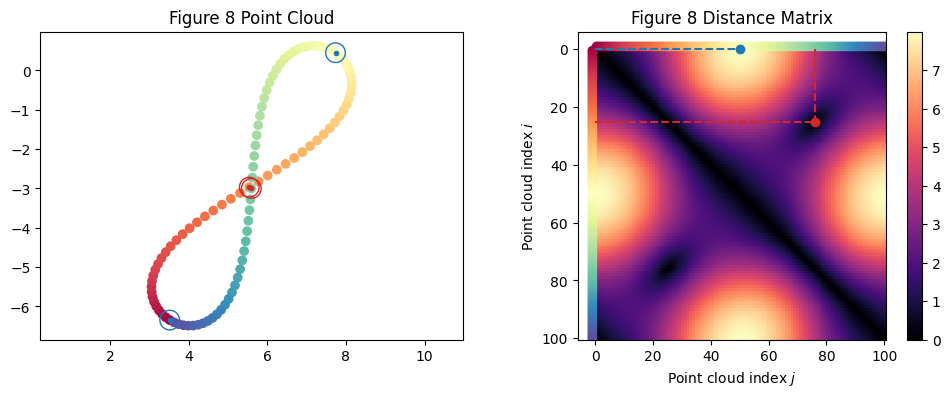

In [4]:
# Find two points that achieve the diameter
i1, j1 = np.unravel_index(np.argmax(D), (N, N))
# Find the closest pair of points are at least 5 apart from the diagonal
I, J = np.meshgrid(np.arange(N), np.arange(N), indexing='ij')
i2, j2 = np.unravel_index(np.argmin(D + np.max(D)*(J - I < 5)), (N, N))

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=np.arange(N), cmap='Spectral')
plt.scatter(X[[i1, j1], 0], X[[i1, j1], 1], s=200, facecolor='none', edgecolor='C0')
plt.scatter(X[[i1, j1], 0], X[[i1, j1], 1], marker='.', c='C0')
plt.scatter(X[[i2, j2], 0], X[[i2, j2], 1], s=200, facecolor='none', edgecolor='C3')
plt.scatter(X[[i2, j2], 0], X[[i2, j2], 1], marker='.', c='C3')
plt.axis("equal");
plt.title("Figure 8 Point Cloud")

plt.subplot(122)
plt.imshow(D, cmap='magma', interpolation='none')
plt.colorbar()
plt.scatter(np.arange(N)+0.5, -1*np.ones(N), c=np.arange(N), cmap='Spectral')
plt.scatter(-1*np.ones(N), np.arange(N)+0.5, c=np.arange(N), cmap='Spectral')
plt.scatter(j1, i1, c='C0')
plt.plot([0, j1], [i1, i1], linestyle='--', c='C0')
plt.plot([j1, j1], [0, i1], linestyle='--', c='C0')
plt.scatter(j2, i2, c='C3')
plt.plot([0, j2], [i2, i2], linestyle='--', c='C3')
plt.plot([j2, j2], [0, i2], linestyle='--', c='C3')
plt.title("Figure 8 Distance Matrix")
plt.xlabel("Point cloud index $j$")
plt.ylabel("Point cloud index $i$")
plt.savefig("Fig8Dist.png", dpi=300, bbox_inches='tight')
plt.savefig("ForwardInverse.svg")

## Classic Multidimensional Scaling

### $D[i, j]^2 =  \sum_{k=0}^{d-1} (X_i[k] - X_j[k])^2 = \sum_{k=0}^{d-1} X_i[k]^2 +  \sum_{k=0}^{d-1} X_j[k]^2 - \sum_{k=0}^{d-1} 2 X_i[k] X_j[k] $

In [5]:
def get_distmat(X, eps=1e-7, sqrt=False):
    G = np.sum(X**2, axis=1, keepdims=True)
    DSqr = G + G.T - 2*X.dot(X.T) # First term, second term, third term
    if sqrt:
        DSqr[DSqr < eps] = eps # Make sure we don't underflow before taking the square root!
        DSqr = np.sqrt(DSqr)
    return DSqr

DSqr = get_distmat(X)

Given a Euclidean point cloud with $N$ points in $d$ dimensions

* X is a $N \times d$ matrix, where each point is along a row

* G is a $N \times 1$ matrix, where $G[i, 0] = \sum_{k=0}^{d-1} X_i[k]^2$

* $1_N$ as $N \times 1$ matrix of all 1's (np.ones((N, 1)))

* $I_N$ is the $N \times N$ identity matrix

### NOTE: (AB)^T = B^T A^T

### $D^2 = G 1_N^T + 1_N G^T - 2 X X^T$

Define a matrix $H$ which has the effect of subtracting off the mean of a vector from all of its coordinates

That is, given a vector $v$ ($N \times 1$), $H v$ = v - np.mean(v)

### $H = I_N -  \frac{1}{N}1_N 1_N^T$


### $H D^2 = H (G 1_N^T + 1_N G^T - 2 X X^T)$

### $H D^2 H = H (G 1_N^T - 2 X X^T) H$

### $H D^2 H = H (- 2 X X^T) H$

### $ -\frac{1}{2} H D^2 H = (H X) (H X)^T$

### $ -\frac{1}{2} H D^2 H = (H X) (H X)^T = U S U^T$, where $U$ is orthonormal, and wlog the diagonal elements of $S$ are in decreasing order

NOTE: $(HX)(HX)^T$ is a "Gram matrix."  
1. It is symmetric; this means we can use the spectral theorem to factorize it into
   an orthonormal basis
2. Positive semidefinite -> eigenvalues (diagonal elements of S) are *nonnegative*

### $ -\frac{1}{2} H D^2 H = (H X) (H X)^T = U S^{1/2} S^{1/2} U^T = (US^{1/2}) (US^{1/2})^T$

### $(H X) (H X)^T = (US^{1/2}) (US^{1/2})^T$

Caveat 1: US^{1/2} may have too many columns:
* H is NxN, X is Nxd, HX Nxd

* U is NXN
* S, S^{1/2} are NxN
* U S^{1/2} is NxN

--------------
Caveat 2: HX is only unique up to a "linear isometry" (i.e. matrix R, s.t. RR^T = I).
Examples: rotations, reflections

$(HXR)(HXR)^T = H X (R R^T) X^T H^T = (HX)(HX)^T$

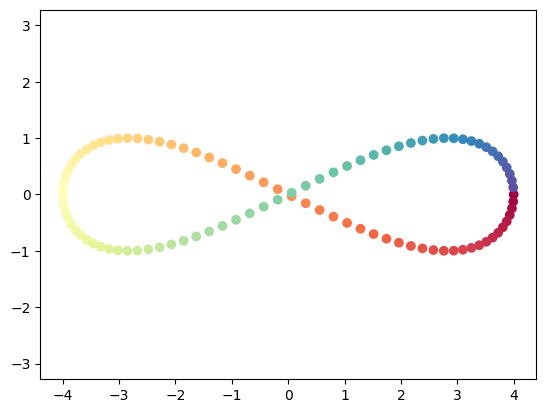

In [6]:
DSqr = get_distmat(X)

## CMDS Algorithm: Given a distance matrix D

## Step 1: Compute the square of the distance matrix
## Step 2: Compute the double centering of this matrix
N = DSqr.shape[0]
H = np.eye(N) - (1/N)*np.ones((N, N))
C = -0.5*(H.dot(DSqr.dot(H)))

## Step 3: Compute the eigenvalue decomposition to get spectral factorization
S, U = np.linalg.eigh(C)
S = S[::-1]
S[S < 0] = 0
U = U[:, ::-1]

## Step 4: Compute US^{1/2} to extract coordinates
#Y = U.dot(np.diag(S**0.5))
Y = U * (S[None, :] ** 0.5)

plt.scatter(Y[:, 0], Y[:, 1], c=np.arange(N), cmap='Spectral')
plt.axis("equal");

### Principal Component Analysis (PCA) And Projected Variance




8768.410231427282


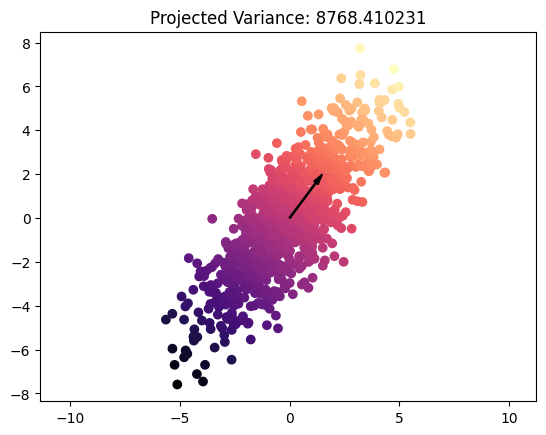

In [7]:
def get_random_pointcloud(seed, N, sigma1=3, sigma2=1):
    """
    Parameters
    ----------
    seed: int
        Random seed for repeatable results
    N: int
        Number of points
    sigma1: float
        Standard deviation along first dimension
    sigma2: float
        Standard deviation along second dimension
    
    Return
    ------
    X: ndarray(N, 2)
        2D point cloud
    """
    np.random.seed(seed)
    u = np.random.rand(2)
    u = u/np.sqrt(np.sum(u**2))
    v = np.array([u[1], -u[0]])
    X = np.zeros((N, 2))
    X = sigma1*np.random.randn(N, 1)*u[None, :]
    X += np.random.randn(N, 1)*v[None, :]
    return X

def plot_proj(X, u):
    p = X.dot(u)
    sqrVar = np.sum(p*p)
    plt.scatter(X[:, 0], X[:, 1], c=p, cmap='magma')

    ax = plt.gca()
    ax.arrow(0, 0, u[0]*2, u[1]*2, head_width = 0.25, head_length = 0.5, fc = 'k', ec = 'k', width = 0.05)
    plt.title("Projected Variance: {:.6f}".format(sqrVar))
    plt.axis("equal")

X = get_random_pointcloud(0, 1000)

A = (X.T).dot(X)
S, U = np.linalg.eigh(A)
S = S[::-1]
U = U[:, ::-1]
u = U[:, 0]
u = u/np.sqrt(np.sum(u**2)) # Normalizes the vector so that |u| = 1
plot_proj(X, u)
print(S[0])

$ U S^{1/2} $

$ (U_i s_u^{1/2})^T U_i s_i^{1/2} = s_i$


In [8]:
def get_cmds(D, k=-1):
    """
    Get CMDS of a distance matrix

    D: ndarray(N, N)
        Distance matrix
    k: int
        The number of largest eigenvalues we want or -1 if we want them all
    """
    ## CMDS Algorithm: Given a distance matrix D
    ## Step 1: Compute the square of the distance matrix
    DSqr = D**2
    ## Step 2: Compute the double centering of this matrix
    N = DSqr.shape[0]
    C = DSqr - np.mean(DSqr, axis=0, keepdims=True) # Subtract column means
    C = C - np.mean(C, axis=1, keepdims=True) # Subtract row means from result
    C *= -0.5
    
    ## Step 3: Compute the eigenvalue decomposition to get spectral factorization
    if k == -1:
        S, U = np.linalg.eigh(C)
    else:
        S, U = scipy.linalg.eigh(C, subset_by_index=[N-k, N-1])
    S = S[::-1]
    U = U[:, ::-1]
    
    ## Step 4: Compute US^{1/2} to extract coordinates
    Y = U[:, S > 0] * (S[None, S > 0] ** 0.5)

    return Y, S

Def. projected variance onto a unit vector $v$

### $ \sum (X_i \cdot v)^2 $

Def. projected variance onto a unit vector $v$

### $ \sum (X_i \cdot v)^2 $

### $(X v)^T (X v) = v^T (X^T X) v$
### Let $A = X^T X$

### Let $A = V S V^T$, where $S$ are the same eigenvalues as $U S U^T$ in CMDS

### $  (\sum_j s_j v^T  V_j V_j^T v)  $

This shows that if I take my $v = V_j$, then the projected variance is $s_j$.  It follows that making $v = V_0$ will maximize the projected variance as $s_0$



Each vector column of $V$ is orthogonal to all other columns, and it's a $d$-dimensional vector.  We can view these vectors as direction vectors in the Euclidean space $\mathbb{R}^d$

Let's suppose we wanted to choose the axis the maximizes the projected variance.





## Non-Euclidean Distance Matrices

It will not be the case that I can perfectly reconstruct a non-Euclidean distance matrix using Euclidean coordinates.

[[3.16227766e-04 1.11803399e+00 2.00000000e+00 1.11803399e+00]
 [1.11803399e+00 3.16227766e-04 1.11803399e+00 1.00000000e+00]
 [2.00000000e+00 1.11803399e+00 3.16227766e-04 1.11803399e+00]
 [1.11803399e+00 1.00000000e+00 1.11803399e+00 3.16227766e-04]]


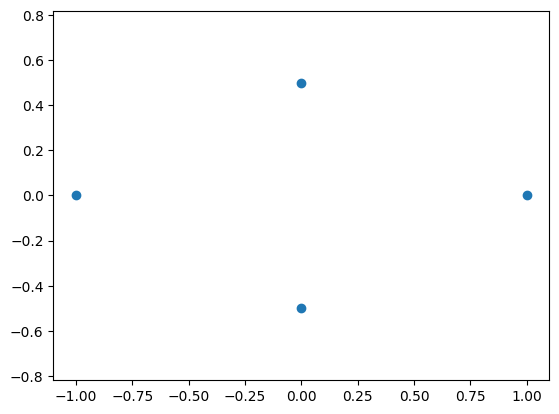

In [9]:
D = np.array([[0, 1, 2, 1],
              [1, 0, 1, 1],
              [2, 1, 0, 1],
              [1, 1, 1, 0]])

Y, S = get_cmds(D)
plt.scatter(Y[:, 0], Y[:, 1])
plt.axis("equal")

D2 = get_distmat(Y, sqrt=True)
print(D2)

### Academic Subject Similarity

From a <a href = "https://compsci290-s2016.github.io/CoursePage/Lectures/26_CanonicalForms/slides.pdf">class I ran years ago</a>

(np.float64(-0.4238101050628694),
 np.float64(0.4508571593772824),
 np.float64(-0.2239736025688495),
 np.float64(0.16300257864713535))

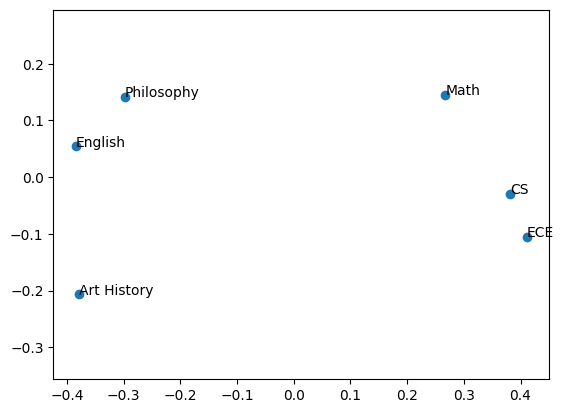

In [10]:
D = np.array([[0.00, 0.36, 0.74, 0.80, 0.81, 0.37],
              [0.36, 0.00, 0.70, 0.80, 0.82, 0.29],
              [0.74, 0.70, 0.00, 0.31, 0.32, 0.59],
              [0.80, 0.80, 0.31, 0.00, 0.20, 0.71],
              [0.81, 0.82, 0.32, 0.20, 0.00, 0.77],
              [0.37, 0.29, 0.59, 0.71, 0.77, 0.00]])
subjects = ["Art History", "English", "Math", "CS", "ECE", "Philosophy"]
Y, S = get_cmds(D)
plt.scatter(Y[:, 0], Y[:, 1])
for (name, [x, y]) in zip(subjects, Y[:, 0:2]):
    plt.text(x, y, name)

plt.axis("equal")


### Rank Choice Voting

In [11]:
def get_kendall_tau(p1, p2):
    """
    Simple O(N^2) algorithm for computing
    """
    N = len(p1)
    ## Step 1: Enumerate and store all pairwise elections for first rater
    pairs1 = set([])
    for i in range(N):
        for j in range(i+1, N):
            pairs1.add((p1[i], p1[j]))

    ## Step 1: Enumerate all pairwise elections for second rater and
    ## check them against the first one
    dist = 0
    for i in range(N):
        for j in range(i+1, N):
            if (p2[i], p2[j]) not in pairs1:
                dist += 1
    return dist

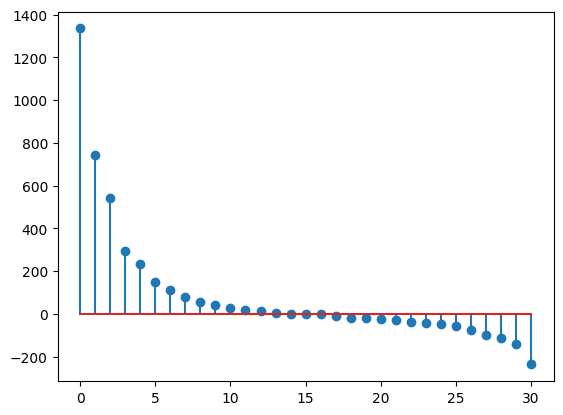

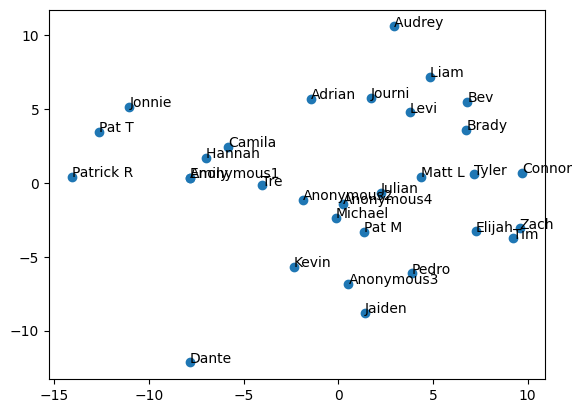

In [12]:
stars = ['Taylor Swift', 'Drake', 'Dua Lipa', 'Miley Cyrus', 'Michael Jackson', 'Nirvana', 'The Beatles', 'Journey']

raters = {
    'Hannah ':    [2, 7, 4, 0, 6, 3, 5, 1], 
    'Anonymous1': [0, 2, 4, 5, 6, 7, 3, 1], 
    'Emily ':     [0, 2, 4, 5, 6, 7, 3, 1], 
    'Audrey ':    [5, 6, 7, 4, 3, 0, 2, 1], 
    'Michael':    [2, 4, 7, 5, 1, 6, 0, 3], 
    'Camila':     [0, 6, 5, 3, 2, 1, 4, 7], 
    'Julian':     [4, 6, 0, 1, 5, 7, 3, 2], 
    'Connor':     [5, 1, 7, 6, 4, 2, 3, 0], 
    'Anonymous2': [4, 5, 0, 3, 1, 6, 2, 7], 
    'Bev':        [6, 5, 4, 7, 1, 3, 2, 0], 
    'Adrian':     [0, 6, 5, 4, 7, 3, 1, 2], 
    'Zach':       [1, 5, 4, 6, 7, 2, 3, 0], 
    'Patrick R':  [0, 3, 2, 4, 5, 7, 6, 1], 
    'Elijah':     [4, 1, 6, 7, 5, 0, 2, 3], 
    'Dante':      [1, 0, 2, 3, 4, 7, 5, 6], 
    'Pedro':      [1, 6, 4, 0, 2, 5, 7, 3], 
    'Kevin':      [4, 2, 0, 1, 6, 5, 7, 3], 
    'Pat M':      [4, 6, 1, 0, 5, 3, 2, 7], 
    'Tyler':      [5, 1, 7, 6, 0, 4, 2, 3], 
    'Tre ':       [4, 0, 6, 3, 5, 1, 2, 7], 
    'Journi':     [7, 4, 6, 5, 0, 2, 3, 1], 
    'Tim':        [1, 4, 6, 5, 7, 2, 3, 0], 
    'Liam ':      [6, 5, 7, 4, 0, 1, 3, 2], 
    'Jonnie ':    [3, 7, 2, 0, 4, 6, 5, 1], 
    'Anonymous3': [4, 1, 0, 5, 2, 7, 6, 3], 
    'Jaiden ':    [1, 4, 6, 2, 0, 3, 5, 7], 
    'Matt L':     [5, 4, 6, 2, 1, 7, 0, 3], 
    'Anonymous4': [4, 6, 0, 1, 3, 5, 7, 2], 
    'Brady':      [7, 5, 6, 1, 4, 0, 2, 3], 
    'Levi':       [6, 4, 5, 7, 0, 1, 3, 2], 
    'Pat T':      [0, 3, 2, 5, 6, 4, 7, 1]
}

people = list(raters.keys())
N = len(people)
D = np.zeros((N, N))
for i in range(N):
    for j in range(i+1, N):
        D[i, j] = get_kendall_tau(raters[people[i]], raters[people[j]])
D = D + D.T # Repeat on the lower triangle

Y, S = get_cmds(D)
plt.figure()
plt.stem(S)

plt.figure()
plt.scatter(Y[:, 0], Y[:, 1])
for (name, [x, y]) in zip(people, Y[:, 0:2]):
    plt.text(x, y, name)

In [13]:
N = 8
print("Max disagreements possible: ", N*(N-1)//2)
print(raters["Dante"])
print(raters["Dante"][::-1])
print(raters["Audrey "]) # Audrey is nearly the reverse of Dante!  They only agree on 5 vs 6 and 0 vs 2
print(get_kendall_tau(raters["Dante"], raters["Audrey "]))

Max disagreements possible:  28
[1, 0, 2, 3, 4, 7, 5, 6]
[6, 5, 7, 4, 3, 2, 0, 1]
[5, 6, 7, 4, 3, 0, 2, 1]
26


### Bending Invariant 3D Shapes

In [14]:
from trimesh import load_off, save_off
import potpourri3d as pp3d
import polyscope as ps
import time

In [15]:
V91, VColors, F91 = load_off("tr_reg_091.off")
solver = pp3d.MeshHeatMethodDistanceSolver(V91, F91)
N = V91.shape[0]
D91 = np.zeros((N, N))
for i in tqdm(range(N)):
    D91[i, :] = solver.compute_distance(i)
tic = time.time()
Y91, S91 = get_cmds(D91, 3)
print("Elapsed time", time.time()-tic)

100%|██████████████████████████████████████| 6890/6890 [00:09<00:00, 697.68it/s]


Elapsed time 29.054359674453735


In [16]:
V99, VColors, F99 = load_off("tr_reg_099.off")
solver = pp3d.MeshHeatMethodDistanceSolver(V99, F99)
N = V99.shape[0]
D99 = np.zeros((N, N))
for i in tqdm(range(N)):
    D99[i, :] = solver.compute_distance(i)
tic = time.time()
Y99, S99 = get_cmds(D99, 3)
print("Elapsed time", time.time()-tic)

100%|██████████████████████████████████████| 6890/6890 [00:12<00:00, 545.92it/s]


Elapsed time 27.763769149780273


In [17]:
ps.init()
ps.register_surface_mesh("Original 91", V91 - np.array([[0, 0, 1.5]]), F91)
ps.register_surface_mesh("Canonical 91", Y91 - np.array([[1, 0, 1.7]]), F91)
ps.register_surface_mesh("Original 99", V99, F99)
ps.register_surface_mesh("Canonical 99", Y99 - np.array([[1, 0, 0]]), F99)
ps.show()

[polyscope] Backend: openGL3_glfw -- Loaded openGL version: 4.6 (Core Profile) Mesa 25.0.7-0ubuntu0.25.04.2


## p-Stress

Given an $N \times N$ distance matrix $D$ and $N$ points $X$ in $k$ Euclidean dimensions, the $p$-stress of $X$ with respect to $D$ is

### $\left( \sum_{i, j} (D_{i, j} - ||X_i - X_j||)^p ) \right) ^{1/p}$

Ex) 2-Stress

### $\sqrt{ \sum_{i, j} (D_{i, j} - ||X_i - X_j||)^2 ) }$


In [18]:
def get_stress_embedding(D, mask, k, n_iters, lr, anchors=[], eps=1e-4, device='cuda'):
    """
    Parameters
    ----------
    D: ndarray(N, N)
        Distance matrix
    k: int
        Number of Euclidean coordinates
    n_iters: int
        Number of iterations

    anchors: lists of lists of [lambj, j, aj]
        Anchors to include
    """
    D = torch.from_numpy(D).to(device)
    mask = torch.from_numpy(mask).to(device)
    N = D.shape[0]
    ## Randomly initialize coordinates of the N points in k dimensions
    X = torch.rand(N, k).to(device).requires_grad_()
    optimizer = torch.optim.Adam([X], lr=lr)
    losses = np.zeros(n_iters)
    pidx = 0
    for i in tqdm(range(n_iters)):
        optimizer.zero_grad()
        G = torch.sum(X**2, dim=1, keepdims=True)
        Di = G + G.T - 2*torch.matmul(X, X.T) # First term, second term, third term
        Di[Di < eps] = 0
        Di = torch.sqrt(Di)
        loss = (torch.sum(mask*(D - Di)**2))**0.5
        for [lamj, j, aj] in anchors:
            dj = torch.sum((X[j, :] - torch.from_numpy(aj).to(device))**2)
            if dj > eps:
                loss += lamj*torch.sqrt(dj)
                
        losses[i] = loss.item()
        loss.backward() # Do backpropagation to figure derivatives of loss wtr each X coordinate
        optimizer.step() # Take step against gradient
    return X.detach().cpu().numpy(), losses

100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 1411.01it/s]


(np.float64(-2.373486316204071),
 np.float64(3.1356726050376893),
 np.float64(-3.370890402793884),
 np.float64(4.513314509391785))

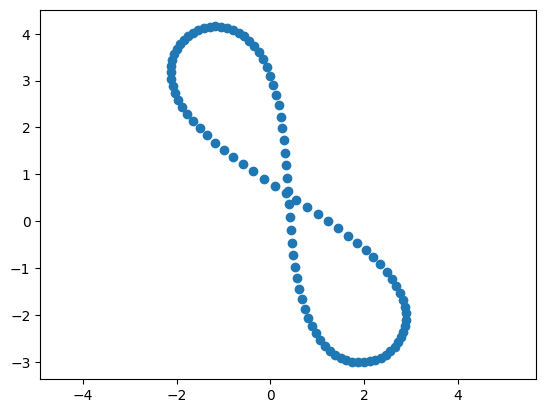

In [19]:
import torch
N = 101
ts = 2*np.pi*(np.linspace(0, 1, N+1))[0:N]
X = np.zeros((N, 2))
X[:, 0] = 4*np.cos(ts)
X[:, 1] = np.sin(2*ts)
eps = 1e-4
D = get_distmat(X, eps=eps, sqrt=True)
Y, losses = get_stress_embedding(D, np.ones_like(D), 2, 1000, 1e-2, eps=eps)

plt.scatter(Y[:, 0], Y[:, 1])
plt.axis("equal")

100%|███████████████████████████████████| 10000/10000 [00:05<00:00, 1714.33it/s]


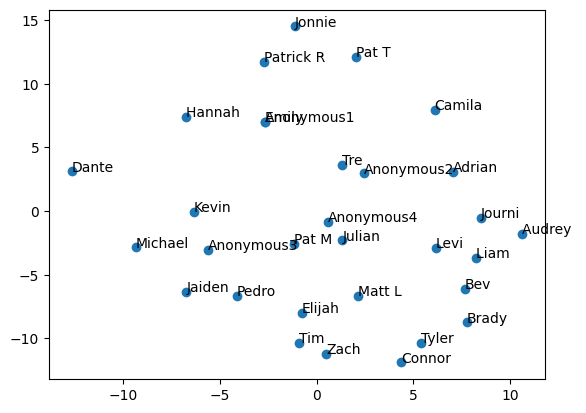

In [20]:
people = list(raters.keys())
N = len(people)
D = np.zeros((N, N))
for i in range(N):
    for j in range(i+1, N):
        D[i, j] = get_kendall_tau(raters[people[i]], raters[people[j]])
D = D + D.T # Repeat on the lower triangle

Y, losses = get_stress_embedding(D, np.ones_like(D), 2, 10000, 1e-2, eps=eps)

plt.figure()
plt.scatter(Y[:, 0], Y[:, 1])
for (name, [x, y]) in zip(people, Y[:, 0:2]):
    plt.text(x, y, name)

In [21]:
Y, losses = get_stress_embedding(D99, np.ones_like(D99), 3, 1000, 1e-2, eps=eps)

100%|███████████████████████████████████████| 1000/1000 [00:34<00:00, 28.85it/s]


### Anchor Points And Masks

Choosing certain points to go to certain locations, as well as masking out certain terms in the stress

### $d(D, X) = \sqrt{ \sum_{i, j} M_{i, j} (D_{i, j} - ||X_i - X_j||)^2 )} +  \sum_{j} \lambda_j ||X_j - a_j||$


100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1065.54it/s]


(np.float64(-10.5),
 np.float64(0.5),
 np.float64(-0.3001678615808487),
 np.float64(0.3729137808084488))

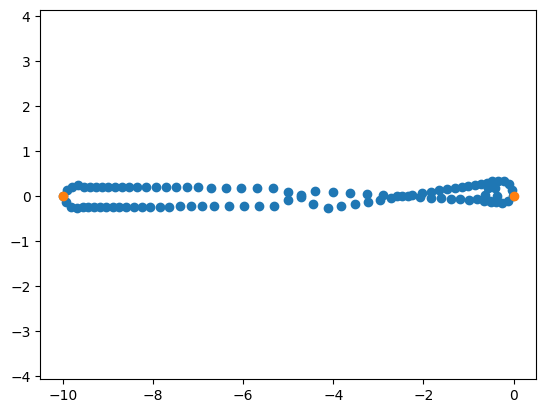

In [22]:
import torch
N = 101
ts = 2*np.pi*(np.linspace(0, 1, N+1))[0:N]
X = np.zeros((N, 2))
X[:, 0] = 4*np.cos(ts)
X[:, 1] = np.sin(2*ts)
eps = 1e-4
D = get_distmat(X, eps=eps, sqrt=True)
mask = 1.0*(D < 0.5)

anchors = [ [1, 50, np.array([-10, 0])  ], [1, 0, np.array([0, 0])  ] ]

Y, losses = get_stress_embedding(D, mask, 2, 10000, 1e-2, anchors=anchors, eps=eps)

plt.scatter(Y[:, 0], Y[:, 1])
for [lamj, j, aj] in anchors:
    plt.scatter(aj[0], aj[1], c='C1')
plt.axis("equal")

In [24]:
D91Euclidean = get_distmat(V91)
mask = 1.0*(D91 < 0.3)

In [25]:
lam = 0.1
anchors = [[lam, 2450, np.array([V91[2450, 0], 0.8, V91[2450, 2]])],
           [lam, 6647, V91[6647, :]],
           [lam, 5988, V91[5988, :]],
           [lam, 411, V91[411, :]]
          ]
Y, losses = get_stress_embedding(D91Euclidean, mask, 3, 1000, 1e-3, anchors=anchors, eps=eps)

100%|███████████████████████████████████████| 1000/1000 [00:35<00:00, 28.10it/s]


In [26]:
ps.init()
ps.register_surface_mesh("Stretched 91", Y, F91)
ps.show()

## References

Elad, Asi, and Ron Kimmel. "Bending invariant representations for surfaces." Proceedings of the 2001 IEEE Computer Society Conference on Computer Vision and Pattern Recognition. CVPR 2001. Vol. 1. IEEE, 2001.

Kendall-Tau Distance:
https://ursinusdatastructures.github.io/F2024/ClassExercises/Week7_KendallTau/
